### imports 

In [1]:
#!conda install -c conda-forge python-graphviz -y

/bin/bash: conda: command not found


In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import tensorflow.experimental.numpy as tnp 

In [4]:
tnp.experimental_enable_numpy_behavior() 

### 최적화의 문제 

`-` $loss=(\frac{1}{2}\beta-1)^2$ 

`-` 기존에 했던 방법은 수식을 알고 있어야 한다는 단점이 있음 

`-` 그래서 확률적 경사하강법을 이용해서 최적해를 찾는 과제를 수행하였음 

`-` 그러나 다양한 `loss` 함수에서 위와 같이 간단히 최적해를 찾는 것은 매우 어려움 $\to$ 대부분의 함수는 비모수적이기 때문이다!!

`-` 그래서 오늘은 그것을 쉽게 해주는 `tf.keras.optimizers`를 사용해서 최적해를 찾을 거얌

### tf.keras.optimizers를 이용한 최적화방법 

#### 방법1: opt.apply_gradients()를 이용 

* 이전까지의 방법

In [29]:
beta = tf.Variable(-10.0)
alpha = 0.01/6

In [30]:
with tf.GradientTape() as tape :
    tape.watch(beta)
    loss = (beta/2-1)**2
slope = tape.gradient(loss,beta)

In [31]:
beta.assign_sub(slope*alpha)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-9.99>

* 이전 방법 + 새로운 방법 ( - `beta.assign_sub(slope*alpha)`)

In [32]:
opt = tf.keras.optimizers.SGD(alpha)

* `opt.apply_gradients()` : 베타 값과 slope의 값을 받아 최적해를 구해준다.

*  즉, 위식을 통해 수식을 몰라도 최적해를 구할 수 있다.

* 아래 과정은 한번에 `iteration` 임

In [33]:
opt.apply_gradients([(slope,beta)]) # beta.assign_sub(slope*alpha)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [34]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.98>

* iteration 2

In [35]:
with tf.GradientTape() as tape :
    tape.watch(beta)
    loss = (beta/2-1)**2
slope = tape.gradient(loss,beta)

In [36]:
opt.apply_gradients([(slope,beta)]) # beta.assign_sub(slope*alpha)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

In [37]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.9700165>

* `interation 1`과 `interation 2` 의 결과가 달라진 것을 확인하였다.

* `for` 문을 이용한다면?

In [40]:
alpha = 0.01/6
beta =  tf.Variable(-10.0)
opt = tf.keras.optimizers.SGD(alpha)

In [41]:
for epoc in range(10000) :
  with tf.GradientTape() as tape :
    tape.watch(beta)
    loss = (beta/2-1)**2
  slope = tape.gradient(loss,beta)
  opt.apply_gradients([(slope,beta)])

In [42]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

* 잠깐, 주소가 같지만 문법이 다름 근데 걍 그런갑다 하자 

In [43]:
opt.learning_rate, opt.lr

(<tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.0016666667>,
 <tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.0016666667>)

In [44]:
id(opt.learning_rate), id( opt.lr)

(139921818271120, 139921818271120)

#### 방법2: opt.minimize()

* 이 함수를 이용하면 `gradienttape`를 안써도 된다. 핳

In [45]:
alpha = 0.01/6
beta =  tf.Variable(-10.0)
opt = tf.keras.optimizers.SGD(alpha)

##### loss 함수 정의 

$$\left(\frac 12\beta-1\right)^2$$

In [50]:
loss_fn = lambda: (beta/2-1)**2 

`-` iter 1

In [51]:
opt.minimize(loss_fn,beta)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [52]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.99>

`-` for

In [53]:
alpha = 0.01/6
beta =  tf.Variable(-10.0)
opt = tf.keras.optimizers.SGD(alpha)
loss_fn = lambda: (beta/2-1)**2 
for epoc in range(10000) :
    opt.minimize(loss_fn,beta)
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

In [54]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

### 회귀분석 문제

`-` ${\bf y} \approx 2.5 + 4 {\bf x}$

In [73]:
tnp.random.seed(43052)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5 + 4*x + epsilon
y_hat = 2.5 + 4*x

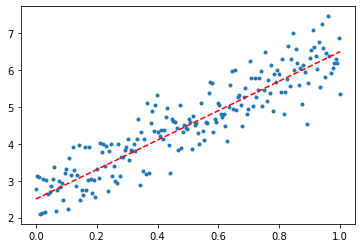

In [74]:
plt.plot(x,y,'.')
plt.plot(x,y_hat,'r--')

### 이론적 풀이

#### 풀이1: 스칼라버전

`-` 포인트 
- $S_{xx}=\sum (x-\bar x)^2$,$\quad S_{xy}=\sum (x-\bar x)(y- \bar y)$
- $\hat{\beta}_0=\bar y - \hat{ \beta_1} \bar x$$,\quad \hat{\beta}_1= \frac {S_{xy}}{S_{xx}} $

In [75]:
Sxx = sum((x-x.mean())**2) 
Sxy = sum((x-x.mean())*(y-y.mean())) 

In [76]:
beta1_hat = Sxy/Sxx 
beta0_hat = y.mean() - beta1_hat*x.mean()

In [77]:
beta0_hat,beta1_hat

(<tf.Tensor: shape=(), dtype=float64, numpy=2.583667211565867>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.933034516733169>)

#### 풀이2: 벡터버전

In [78]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 

In [79]:
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

* $\hat \beta  = (X^{T}X)^{-1} X^{T} y$

In [80]:
tf.linalg.inv(X.T@X)@ X.T @y 

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.58366721],
       [3.93303452]])>

#### 풀이3: 벡터버전, 손실함수의 도함수이용 (경사하강법을 이용한 풀이)

(단, 텐서플로우의 미분기능을 사용하지 않음 ) $\to$  `gradienttape` X

In [82]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

`-` 초기값 설정

In [83]:
beta_hat = tnp.array([-5.0,10.0]).reshape(2,1)

`-` 포인트
- $loss'(\beta)=-2X'y +2X'X\beta$
- $\beta_{new} = \beta_{old} - \alpha \times loss'(\beta_{old})$

In [89]:
slope = -2*X.T@y + 2*X.T@X@beta_hat

In [90]:
slope

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-1820.07378797],
       [ -705.77222696]])>

In [87]:
alpha = 0.001

In [88]:
step = slope * alpha
step

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-1.82007379],
       [-0.70577223]])>

In [91]:
for epoc in range(1000) : 
  slope = -2*X.T@y + 2*X.T@X@beta_hat
  beta_hat = beta_hat - alpha*slope

In [92]:
beta_hat

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.58366721],
       [3.93303452]])>

### GradientTape를 이용 

#### 풀이1: 벡터버전

`-` 포인트
```python
## 포인트코드1: 그레디언트 테입  
with tf.GradientTape() as tape: 
    loss = 
## 포인트코드2: 미분 
slope = tape.gradient(loss,beta_hat) 
## 포인트코드3: update 
beta_hat.assign_sub(slope*alph) 
```

In [102]:
y=y.reshape(N,1) # N=200 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [103]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [104]:
alpha=0.1

In [105]:
for epoc in range(1000):   
    with tf.GradientTape() as tape: 
        tape.watch(beta_hat)
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N 
    slope = tape.gradient(loss,beta_hat) 
    beta_hat.assign_sub(slope * alpha) 

In [106]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이2: 스칼라버전

`-` 포인트
```python
## 포인트코드: 미분
slope0,slope1 = tape.gradient(loss,[beta0_hat,beta1_hat])
```

In [120]:
y=y.reshape(-1) # N=200 
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [117]:
beta0_hat = tf.Variable(-5.0)
beta1_hat = tf.Variable(10.0)
alpha = 0.1

In [121]:
for epoc in range(1000):   
    with tf.GradientTape() as tape: 
        yhat = beta0_hat + beta1_hat*x 
        loss = tf.reduce_sum((y-yhat)**2) / N  #loss = sum((y-yhat)**2) / N 
    slope0,slope1 = tape.gradient(loss,[beta0_hat,beta1_hat]) 
    beta0_hat.assign_sub(slope0 * alpha) 
    beta1_hat.assign_sub(slope1 * alpha) 

In [122]:
beta0_hat, beta1_hat 

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.5836616>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.9330447>)

### GradientTape + opt.apply_gradients

#### 풀이1: 벡터버전 

`-` 포인트 
```python
## 포인트코드: 업데이트
opt.apply_gradients([(slope,beta_hat)])  ## pair의 list가 입력 
```

In [123]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [124]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [125]:
alpha=0.1
opt = tf.optimizers.SGD(alpha)  
### tf.keras.optimizers.SGD 와 똑같은 위치에 있는 모듈이다 그냥 똑같은거다.

In [126]:
for epoc in range(1000): 
    with tf.GradientTape() as tape: 
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N 
    slope = tape.gradient(loss,beta_hat)  
    opt.apply_gradients( [(slope,beta_hat),(slope,beta_hat)] )

In [128]:
(y-yhat).T @ (y-yhat) / N, beta_hat 

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.25493942]])>,
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
 array([[2.58366721],
        [3.93303452]])>)

#### 풀이2: 스칼라버전 

`-` 포인트
```python
## 포인트코드: 업데이트 
opt.apply_gradients([(slope0,beta0_hat),(slope1,beta1_hat)]) ## pair의 list가 입력 
```

In [129]:
y=y.reshape(-1)
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [130]:
beta0_hat = tf.Variable(-5.0)
beta1_hat = tf.Variable(10.0) 

In [131]:
alpha=0.1

In [132]:
opt = tf.optimizers.SGD(alpha) 

In [133]:
for epoc in range(1000): 
    with tf.GradientTape() as tape: 
        yhat = beta0_hat + beta1_hat*x 
        loss = tf.reduce_sum((y-yhat)**2) / N 
    slope0,slope1 = tape.gradient(loss,[beta0_hat,beㅠta1_hat])  
    opt.apply_gradients( [(slope0,beta0_hat),(slope1,beta1_hat)] )

In [134]:
beta0_hat,beta1_hat

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.58366>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.933048>)

### opt.minimize

#### 풀이1: 벡터버전, 사용자정의 손실함수 with lambda

In [136]:
y=y.reshape(N,1)
X.shape,y.shape

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [137]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [138]:
alpha=0.1
opt = tf.optimizers.SGD(alpha) 
loss_fn = lambda: (y-X@beta_hat).T @ (y-X@beta_hat)/N

In [139]:
(y-X@beta_hat).T @ (y-X@beta_hat)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4811.45696758]])>

In [140]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat) # 미분 + update 

In [142]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이2: 스칼라버전, 사용자정의 손실함수 with lambda

In [146]:
y=y.reshape(-1)
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [147]:
beta0_hat = tf.Variable(-5.0)
beta1_hat = tf.Variable(10.0) 

In [148]:
alpha=0.1
opt = tf.optimizers.SGD(alpha) 
loss_fn = lambda: tf.reduce_sum((y-beta0_hat - beta1_hat*x)**2)/N

In [149]:
for epoc in range(1000):
    opt.minimize(loss_fn,[beta0_hat,beta1_hat]) # 미분 + update 

In [ ]:
beta0_hat, beta1_hat

`-` 포인트
```python
## 포인트코드: 미분 & 업데이트 = minimize 
opt.minimize(loss_fn,[beta0_hat,beta1_hat])
```

#### 풀이3: 벡터버전, 사용자정의 (짧은) 손실함수 

`-` 포인트
```python
## 포인트코드: 손실함수정의 
def loss_fn():
    return ??
```

In [150]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [151]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [152]:
alpha=0.1
opt = tf.optimizers.SGD(alpha)

In [153]:
def loss_fn():
    return (y-X@beta_hat).T @ (y-X@beta_hat)/N

In [154]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat) # 미분 + update 

In [155]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이4: 벡터버전, 사용자정의 (긴) 손실함수 


```python
def loss_fn():
    yhat = X@beta_hat 
    loss = (y-yhat).T @ (y-yhat) / N
    return loss
```

In [156]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [157]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [158]:
alpha=0.1
opt = tf.optimizers.SGD(alpha)

In [159]:
def loss_fn():
    yhat = X@beta_hat 
    loss = (y-yhat).T @ (y-yhat) / N
    return loss

In [160]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat) # 미분 + update 

In [161]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이5: 벡터버전, 사용자정의 손실함수 <- tf.losses.MSE 

`-` 포인트
```python
## 포인트코드: 미리구현되어있는 손실함수 이용 
tf.losses.MSE(y,yhat)
```

In [164]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [165]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [166]:
alpha=0.1
opt = tf.optimizers.SGD(alpha) 

In [167]:
def loss_fn():
    yhat= X@beta_hat
    loss = tf.losses.MSE(y.reshape(-1),yhat.reshape(-1))
    return loss

In [168]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat) # 미분 + update 

In [169]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이6: 벡터버전, 사용자정의 손실함수 <- tf.losses.MeaSquaredError

`-` 포인트
```python
## 포인트코드: 클래스로부터 손실함수 오브젝트 생성 (함수를 찍어내는 클래스) 
mse_fn = tf.losses.MeanSquaredError()
mse_fn(y,yhat)
```

In [170]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [171]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [172]:
alpha=0.1
opt = tf.optimizers.SGD(alpha) 

In [173]:
mseloss_fn = tf.losses.MeanSquaredError()

In [174]:
mseloss_fn(y.reshape(-1),yhat.reshape(-1))

<tf.Tensor: shape=(), dtype=float64, numpy=0.25493940711021423>

In [175]:
def loss_fn():
    yhat= X@beta_hat
    loss = mseloss_fn(y.reshape(-1),yhat.reshape(-1))
    return loss

In [176]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat) # 미분 + update 

In [177]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

### tf.keras.Sequential

`-` $\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$ 의 서로다른 표현 

In [178]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

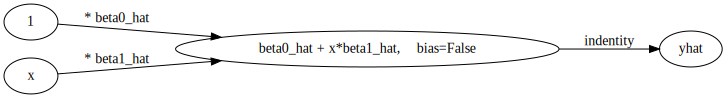

In [ ]:
gv(''' 
    "1" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta0_hat"]
    "x" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta1_hat"]
    "beta0_hat + x*beta1_hat,    bias=False" -> "yhat"[label="indentity"]
    ''')

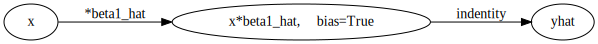

In [ ]:
gv('''
"x" -> "x*beta1_hat,    bias=True"[label="*beta1_hat"] ;
"x*beta1_hat,    bias=True" -> "yhat"[label="indentity"] ''')


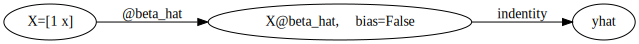

In [ ]:
gv('''
"X=[1 x]" -> "X@beta_hat,    bias=False"[label="@beta_hat"] ;
"X@beta_hat,    bias=False" -> "yhat"[label="indentity"] ''')


#### 풀이1: 벡터버전, 사용자정의 손실함수 

`-` 포인트
```python
## 포인트코드1: 네트워크 생성 
net = tf.keras.Sequential()

## 포인트코드2: 네트워크의 아키텍처 설계 
net.add(tf.keras.layers.Dense(1,input_shape=(2,),use_bias=False)) 

## 포인트코드3: 네트워크 컴파일 = 아키텍처 + 손실함수 + 옵티마이저
net.compile(opt,loss=loss_fn2)

## 포인트코드4: 미분 & update 
net.fit(X,y,epochs=1000,verbose=0,batch_size=N) 
```

In [179]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [180]:
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(units=1,input_shape=(2,),use_bias=False)) # 아키텍처 설계 = yhat을 만들계획 

In [181]:
def loss_fn2(y,yhat): ## 손실함수의 정의 
    return (y-yhat).T @ (y-yhat) / N  

In [182]:
alpha=0.1
opt=tf.optimizers.SGD(alpha) ## 옵티마이저의 선택 

In [183]:
net.compile(opt,loss=loss_fn2) ## 컴파일 = 아키텍처 + 손실함수 + 옵티마이저 

In [184]:
net.fit(X,y,epochs=1000,verbose=0,batch_size=N) # 미분 & update 의 반복

In [185]:
net.weights

[<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[2.5836728],
        [3.9330244]], dtype=float32)>]